# Open AI's Gym Basics

## Initialization

In [ ]:
# Install required libraries
!pip install -qU gym pygame

In [8]:
# Import libraries
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym

import matplotlib.pyplot as plt

print(f"PyTorch Version: {torch.__version__}")
print("Gym:", gym.__version__)
!nvidia-smi # check if GPU is available
%matplotlib inline

PyTorch Version: 2.2.2
Gym: 0.26.2
zsh:1: command not found: nvidia-smi


In [9]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cpu


In [10]:
# Define the environment
env = gym.make('CartPole-v1')

In [11]:
# Create the DQN model class
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)
        
    def forward(self, state):       
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
# Create the Agent class
class Agent():
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(0)

        # Hyperparameters
        self.buffer_size = 2000
        self.batch_size = 64
        self.gamma = 0.99
        self.lr = 0.0025
        self.update_every = 4 

        # Q-Network
        self.local = DQNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.local.parameters(), lr=self.lr)

        # Replay memory
        self.memory = deque(maxlen=self.buffer_size) 
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.append(self.experience(state, action, reward, next_state, done))

        # Learn every update_every time steps
        self.t_step = (self.t_step + 1) % self.update_every

        # If enough samples are available in memory, get random subset and learn
        if self.t_step == 0 and len(self.memory) > self.batch_size:
            experiences = self.sample_experiences()
            self.learn(experiences, self.gamma)

    def act(self, state, eps=0.):
        if random.random() <= eps:
            return random.choice(np.arange(self.action_size))
        
        # Epsilon-greedy action selection
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.local.eval()
        with torch.no_grad():
            action_values = self.local(state)
        self.local.train()
        return np.argmax(action_values.cpu().data.numpy())

    def learn(self, experiences, gamma): 
        states, actions, rewards, next_states, dones = experiences

        # Get expected Q values from local model
        Q_expected = self.local(states).gather(1, actions)

        # Get max predicted Q values (for next states) from local model
        Q_targets_next = self.local(next_states).detach().max(1)[0].unsqueeze(1)

        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample_experiences(self):
        experiences = random.sample(self.memory, k=self.batch_size)        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)        
        return (states, actions, rewards, next_states, dones)

In [13]:
# Create an Agent instance
agent = Agent(env.observation_space.shape[0], env.action_space.n)

Episode 100	Average Score: 14.25 	Epsilon: 0.9512175302423342175302423344
Episode 200	Average Score: 17.26 	Epsilon: 0.90481478984032691478984032694
Episode 300	Average Score: 15.13 	Epsilon: 0.86067568971865286756897186528
Episode 400	Average Score: 26.91 	Epsilon: 0.818689803913795189803913795171
Episode 500	Average Score: 24.77 	Epsilon: 0.778752093313461575209331346153
Episode 600	Average Score: 37.54 	Epsilon: 0.740762642872678876264287267885
Episode 700	Average Score: 42.54 	Epsilon: 0.704626411649133862641164913383
Episode 800	Average Score: 49.43 	Epsilon: 0.670252995032407425299503240745
Episode 900	Average Score: 43.62 	Epsilon: 0.637556398572254755639857225422
Episode 1000	Average Score: 66.57 	Epsilon: 0.60645482284009764548228400974
Episode 1100	Average Score: 75.08 	Epsilon: 0.576870458785509468704587855094
Episode 1200	Average Score: 66.07 	Epsilon: 0.548729293075715872929307571586
Episode 1300	Average Score: 66.15 	Epsilon: 0.521960922931103419609229311034
Episode 1400	

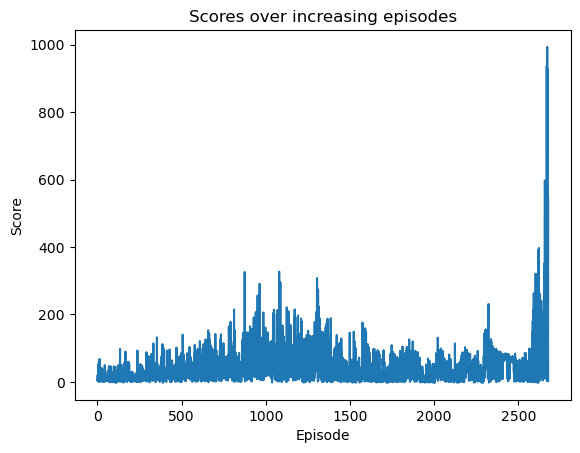

In [14]:
# Initialize variables
scores = [] # Scores from each episode
scores_window = deque(maxlen=100) # Last 100 scores
n_episodes = 5000
max_t = 5000
eps_start = 1.0
eps_end = 0.001
eps_decay = 0.9995
eps = eps_start

# Perform deep Q-learning
for i_episode in range(1, n_episodes+1):
    state_tuple = env.reset()
    state = state_tuple if isinstance(state_tuple, np.ndarray) else state_tuple[0]
    state = np.array(state)
    state_size = env.observation_space.shape[0]
    if len(state.shape) == 1:
        state = np.reshape(state, [1, state_size])
        
    score = 0

    for _ in range(max_t):
        action = agent.act(state, eps)
        result = env.step(action)
        
        # Extract the necessary elements from the result
        next_state, reward, done, *_ = result

        # Handle next_state
        next_state = np.array(next_state)

        # Ensure next_state has the correct shape
        if len(next_state.shape) == 1:
            next_state = np.reshape(next_state, [1, state_size])
        
        reward = reward if not done or score == 499 else -10
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break

    # Save most recent score
    scores_window.append(score)
    scores.append(score)

    # Decrease epsilon
    eps = max(eps_end, eps_decay * eps)

    # Print results
    print('\rEpisode {}\tReward {} \tAverage Score: {:.2f} \tEpsilon: {}'.format(i_episode, score, np.mean(scores_window), eps), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f} \tEpsilon: {}'.format(i_episode, np.mean(scores_window), eps))
    if i_episode > 10 and np.mean(scores[-10:]) > 450:
        break

# Plot the scores
plt.plot(scores)
plt.title('Scores over increasing episodes')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()